In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vitt-path/other/default/1/vit_model.pth
/kaggle/input/vitt-path/other/default/1/__huggingface_repos__.json
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/README.md.txt
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-173.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-334.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-309.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-487.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-178.png
/kaggle/input/t

In [5]:
pip install torch torchvision timm opencv-python matplotlib numpy pillow


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import cv2


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
import torch
from timm import create_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the ViT model architecture (num_classes must match your trained model)
vit_model = create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
vit_model.to(device)

# Now load the saved weights
vit_model.load_state_dict(torch.load('/kaggle/input/vitt-path/other/default/1/vit_model.pth', map_location=device))
vit_model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [7]:
vit_model.load_state_dict(torch.load('/kaggle/input/vitt-path/other/default/1/vit_model.pth', map_location=device))
vit_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [80]:
from PIL import Image
from torchvision import transforms

# Load image
image = Image.open("/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-104.png").convert("RGB")

# Define transform (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Preprocess image
input_tensor = transform(image).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]


In [81]:
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.feature = None
        self.gradient = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.feature = self.reshape_transform(output)

        def backward_hook(module, grad_input, grad_output):
            self.gradient = self.reshape_transform(grad_output[0])

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def reshape_transform(self, tensor, height=14, width=14):
        tensor = tensor[:, 1:, :]  # remove CLS token
        B, N, D = tensor.shape
        result = tensor.reshape(B, height, width, D)
        result = result.permute(0, 3, 1, 2)  # [B, C, H, W]
        return result

    def __call__(self, input_tensor):
     self.model.zero_grad()
     output = self.model(input_tensor)

     class_idx = output.argmax(dim=1).item()
     score = output[0, class_idx]
     score.backward()

     gradients = self.gradient[0].detach().cpu().numpy()
     activations = self.feature[0].detach().cpu().numpy()
     weights = np.mean(gradients, axis=(1, 2))

     cam = np.sum(weights[:, None, None] * activations, axis=0)
     cam = np.maximum(cam, 0)
     cam -= cam.min()
     cam /= (cam.max() + 1e-8)  # Add small epsilon here
     cam = cv2.resize(cam, (224, 224))
     return cam



In [82]:
import numpy as np


In [83]:
# Use the last transformer block's norm layer as target
target_layer = vit_model.blocks[-1].norm1

# Create Grad-CAM object (instantiate the class)
gradcam = GradCam(vit_model, target_layer)

# Generate heatmap by calling the object
heatmap = gradcam(input_tensor)


In [84]:
print(f"Heatmap min: {heatmap.min()}, max: {heatmap.max()}, mean: {heatmap.mean()}")


Heatmap min: 0.0, max: 0.9499335289001465, mean: 0.029697714373469353


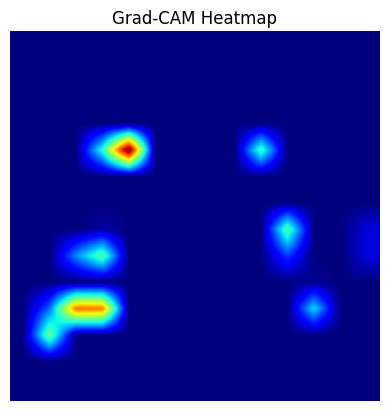

In [85]:
import matplotlib.pyplot as plt

plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('Grad-CAM Heatmap')
plt.show()


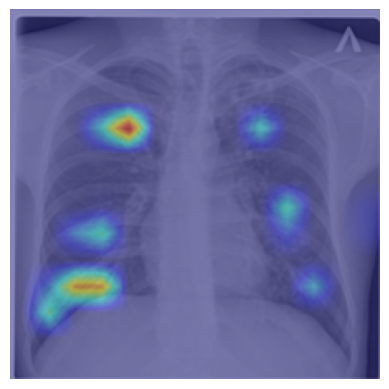

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Suppose:
# - `heatmap` is your Grad-CAM output, a 2D numpy array normalized between 0 and 1, shape (224, 224)
# - `pil_image` is your original PIL image before preprocessing

# 1. Convert heatmap to 0-255 and apply colormap
heatmap_uint8 = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)  # shape (224,224,3), BGR format

# 2. Convert original image to numpy array and resize to 224x224 (if not already)
original_img = np.array(image.resize((224, 224)))  # shape (224,224,3), RGB

# 3. Convert original image from RGB to BGR (OpenCV uses BGR)
original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

# 4. Overlay heatmap onto original image
overlay = cv2.addWeighted(original_img_bgr, 0.6, heatmap_color, 0.4, 0)

# 5. Convert back to RGB for matplotlib display
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# 6. Display with matplotlib
plt.imshow(overlay_rgb)
plt.axis('off')
plt.show()


In [11]:
output = vit_model(input_tensor)
print(output.shape)  # Should be [1, num_classes], e.g., [1, 2]
print(output)        # Check if logits look reasonable (not all zeros)


torch.Size([1, 2])
tensor([[-5.9921,  6.5609]], grad_fn=<AddmmBackward0>)


In [ ]:
output = vit_model(input_tensor)
print(output.shape)  # Should be [1, num_classes], e.g., [1, 2]
print(output)        # Check if logits look reasonable (not all zeros)
